In [1]:
import os
from os.path import join
import glob

import nibabel as nib
import dicom
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Goal: build affine transform to map 3D volume to RAS+

## Step 1: Build the affine transformation that will map the 3D array to DICOM patient reference coordinate system (RCS)

The DICOM tags for each slice contain information that can be used to align the slice in the DICOM patient RCS. This coordinate system is right-handed, and has axes that correspond to LPS+:

* 1st axis, X: increases toward patient's Left
* 2nd axis, Y: increases toward patient's Posterior
* 3rd axis, Z: increases toward patient's Superior

Using the tags 'ImagePositionPatient' and 'ImageOrientationPatient', you can build an affine that will map the pixel data for each slice to the LPS+ coordinate system


### Obtain some basic information about this series:

In [2]:
sliceFiles = glob.glob('data/series0017/*.IMA')
print('total number of slices: {}'.format(len(sliceFiles)))

total number of slices: 52


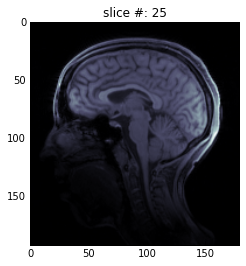

In [3]:
# load a slice near the middle of the volume, just for visualizaing
sliceNum = 25
slice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm = dicom.read_file(slice_fname[0])

plt.title('slice #: {}'.format(dcm.InstanceNumber))
plt.imshow(dcm.pixel_array, cmap='bone')


### Start building the affine matrix

Following along here: (http://nipy.org/nibabel/dicom/dicom_orientation.html#dicom-affines-again)

In [4]:
# start with an identity matrix. Subsequent steps will overwrite values in the matrix
affine = np.eye(4)
affine

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

The first 3 rows of the **first** column should represent the *direction cosines* for the column-axis. That is, the axis that points ALONG a single column (passing OVER rows); y-axis if it was Cartesian.  

The first 3 rows of the **second** column should represent the *direction cosines* for the row-axis. That is, the axis that points ALONG a single row (passing OVER columns); x-axis if it was Cartesian. 

**Note**  the order of these columns in the affine matrix is flipped from what the DICOM specifications say (DICOM specifics say that the first column should represent direction cosines of the row-axis, and the second column should reprsent direction cosines for the column axis). We are swapping that because our pixel data for each slice will be reprented as a numpy array with (row, col) indexing, whereas DICOM expects (col, row) indexing (or in other words, (x,y)). 

These 6 values should be the same for all slices in our image, so we can use the DICOM tag 'ImageOrientationPatient' from a single slice

In [5]:
# read in the first slice
firstSlice_fname = 'data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.0001.2017.10.24.12.31.58.663479.31905939.IMA'
dcm_first = dicom.read_file(firstSlice_fname)

In [6]:
np.set_printoptions(precision=3, suppress=True)

# extract the reformat the ImageOrientationPatient Info
iop = dcm_first.ImageOrientationPatient
print('ImageOrientationPatient:')
print(iop, end='\n\n')

# reshape the image orientation patient
iop = np.array(iop).reshape(3,2, order='F')
print('orig -----')
print(iop, end='\n\n')

# swap the columns
iop = iop[:,[1,0]]
print('swapped -----')
print(iop)

ImageOrientationPatient:
['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']

orig -----
[[ 0.056  0.04 ]
 [ 0.998 -0.002]
 [ 0.    -0.999]]

swapped -----
[[ 0.04   0.056]
 [-0.002  0.998]
 [-0.999  0.   ]]


The direction cosines need to be multiplied by the pixel spacing along each direction. The DICOM tag PixelSpacing has 2 values: 

* pixel spacing between adjacent ROWS
* pixel spacing between adjacent COLS

In [7]:
pixelSpacing = dcm_first.PixelSpacing
print('adjacent rows (i.e. Vertical) resolution: {}'.format(pixelSpacing[0]))
print('adjacent cols (i.e. Horiz) resolution: {}'.format(pixelSpacing[1]))

adjacent rows (i.e. Vertical) resolution: 1.3333333730698
adjacent cols (i.e. Horiz) resolution: 1.3333333730698


In [8]:
# multiply column-axis directional cosines by the vertical resolution
iop[:,0] = iop[:,0] * pixelSpacing[0]


# multiple row-axis directional cosines by the horizontal resolution
iop[:,1] = iop[:,1] * pixelSpacing[1]

iop

array([[ 0.053,  0.074],
       [-0.003,  1.331],
       [-1.332,  0.   ]])

Insert the iop matrix into the affine matrix

In [9]:
affine[:3,:2] = iop
print('Current state of the affine:')
affine

Current state of the affine:


array([[ 0.053,  0.074,  0.   ,  0.   ],
       [-0.003,  1.331,  0.   ,  0.   ],
       [-1.332,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

### Next, insert imagePatientPosition info
The fourth column of the affine matrix will specify the translation needed to take the origin of the DICOM refernce coordinate system

It can be obtained from the ImagePositionPatient field of the first slice

In [10]:
ipp = dcm_first.ImagePositionPatient
print('Image Position Patient:')
print(ipp, end='\n\n')

affine[:3,3] = ipp
print('Current state of the affine:')
affine

Image Position Patient:
['-88.150703580322', '-134.38821883415', '59.742053192921']

Current state of the affine:


array([[   0.053,    0.074,    0.   ,  -88.151],
       [  -0.003,    1.331,    0.   , -134.388],
       [  -1.332,    0.   ,    1.   ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

### Next, figure out the 3rd column of the affine matrix
The 3rd column will represent info about the Z dimension of our image matrix. It can be filled by taking the difference in ImagePositionPatient between the first and last slice, and dividing by 1-(total number of slices). 

In [11]:
# read in the last slice
sliceNum = 52
lastSlice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm_last = dicom.read_file(lastSlice_fname[0])

# get the ipp from the last slice in the file
ipp_last = dcm_last.ImagePositionPatient

# subtract the last slice IPP from the first slice IPP
ipp_diff = np.array(ipp)-np.array(ipp_last)
ipp_diff

array([-152.638,    8.534,   -6.14 ])

In [12]:
# divide each value by 1-nSlices
ipp_diffBySlice = ipp_diff/(1-dcm_last.InstanceNumber)
ipp_diffBySlice

array([ 2.993, -0.167,  0.12 ])

In [13]:
# place in the affine
affine[:3,2] = ipp_diffBySlice
affine

array([[   0.053,    0.074,    2.993,  -88.151],
       [  -0.003,    1.331,   -0.167, -134.388],
       [  -1.332,    0.   ,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

### Affine complete
the affine now represents the linear transform to bring each slices into LPS+ space. 

Use the aff2axcodes method to figure out the voxel order of the image array based on the affine

In [14]:
nib.aff2axcodes(affine)

('I', 'A', 'R')

If I'm reading this right, it says the first axis of the image array extends toward the patient's inferior; the 2nd axis extents to the patient's anterior; and the 3rd axis extends toward the patients right. 

But this is not consistent with how the data appears to have been acquired. The slices were sagital, and the first axis of the pixel_array of each slice (i.e. row index) does seem to extend toward the patient's inferior. However, the 2nd axis (i.e. col index) increases toward the patient's posterior. See:

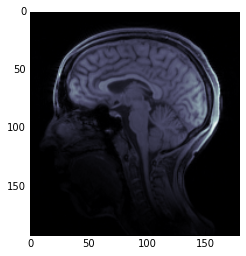

In [15]:
plt.imshow(dcm.pixel_array, cmap='bone')

Moreover, the slices appear to be increasing toward the patient's left. This can be verified by the placement of the vitamin capsule on the patient's left temple that is visible in slice 49 (of 52).  

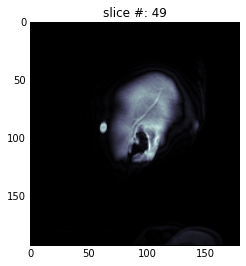

In [18]:
# load a slice near the middle of the volume, just for visualizaing
sliceNum = 49
slice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm = dicom.read_file(slice_fname[0])

plt.title('slice #: {}'.format(dcm.InstanceNumber))
plt.imshow(dcm.pixel_array, cmap='bone')

## Questions:
1. Why does nib.aff2axcodes(affine) report that the voxel order is flipped along the 2nd and 3rd axes? Is there a mistake in how the affine matrix is being constructed?

2. Once there is an affine that will map the voxel matrix to LPS+ space, what are the manipulations needed to produce an affine matrix that will map to RAS+ so that the voxel matrix can be written out as a Nifti formatted file?